In [51]:
import pandas as pd
import numpy as np
import networkx as nx
import numpy as np
import seaborn as sns
import datetime as dt
from lifetimes.plotting import *
from lifetimes.utils import *
#from lifetimes.estimation import *
import lifetimes
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes import GammaGammaFitter

In [9]:
df = pd.read_excel("Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

### Taking not null customers and which have at least 1 order.

In [11]:
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]

### Let's add sales column by multiplying Quantity with Unit price, and show only customers, date and sales

In [12]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
show = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[show]

### Let's count number of distinct elements in specified axis

In [15]:
print(df.head())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34


In [13]:
print(df['CustomerID'].nunique())

4339


In [14]:
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


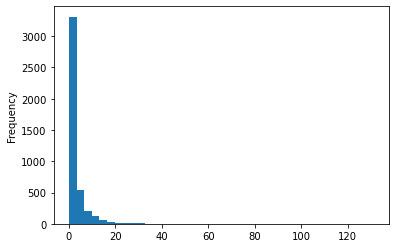

In [17]:
data['frequency'].plot(kind='hist', bins=40)
print(data['frequency'].describe()) 
print(sum(data['frequency'] == 0)/float(len(data)))

In [18]:
from lifetimes import BetaGeoFitter

### Lets's use BetaGeoFitter

In [19]:
betageofit = BetaGeoFitter(penalizer_coef=0.0)
betageofit.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

In [22]:
print(betageofit)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [23]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

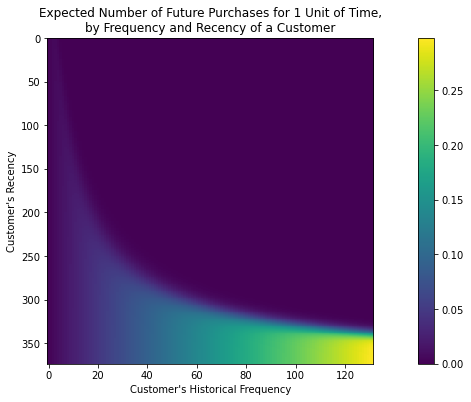

In [24]:
figure = plt.figure(figsize=(16,6))
plot_frequency_recency_matrix(betageofit)

In [25]:
from lifetimes.plotting import plot_probability_alive_matrix

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

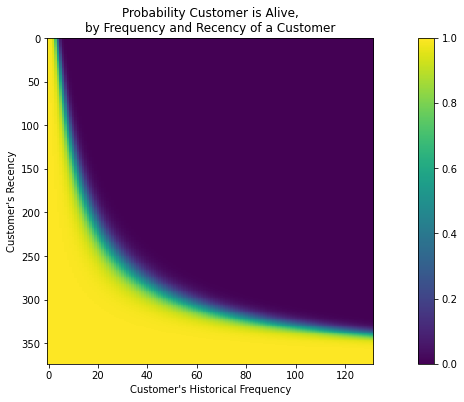

In [26]:
figure = plt.figure(figsize=(16,6))
plot_probability_alive_matrix(betageofit)

In [27]:
data['Purchases_Predicted'] = betageofit.conditional_expected_number_of_purchases_up_to_time(1, data['frequency'], data['recency'], data['T'])

In [28]:
data.sort_values(by='Purchases_Predicted').tail(10)

,frequency,recency,T,monetary_value,Purchases_Predicted
CustomerID,,,,,
16422.0,47.0,352.0,369.0,702.472340,0.109172
13798.0,52.0,371.0,372.0,706.650962,0.119809
14527.0,53.0,367.0,369.0,155.016415,0.122912
13089.0,65.0,367.0,369.0,893.714308,0.150316
12971.0,70.0,369.0,372.0,159.211286,0.160632
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

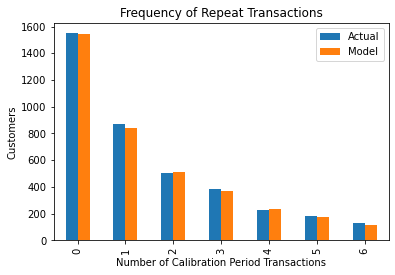

In [30]:
plot_period_transactions(betageofit)

In [33]:
summary_hold = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-09' )

In [34]:
print(summary_hold.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                184.0  
12347.0                184.0  
12348.0                184.0  
12350.0                184.0  
12352.0                184.0  


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

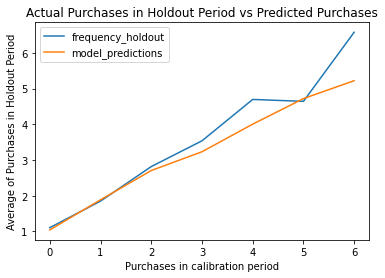

In [36]:
betageofit.fit(summary_hold['frequency_cal'], summary_hold['recency_cal'], summary_hold['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(betageofit, summary_hold)

In [37]:
data.loc[12347]

frequency                6.000000
recency                365.000000
T                      367.000000
monetary_value         599.701667
Purchases_Predicted      0.015656
Name: 12347.0, dtype: float64

### Let's predict for 10 additional periods for above element
### The below function is an alias to "bfg.conditional_expected_number_of_purchases_up_to_time"

In [38]:
betageofit.predict(10, data.loc[12347]['frequency'], data.loc[12347]['recency'], data.loc[12347]['T'])

0.15727743137863798

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

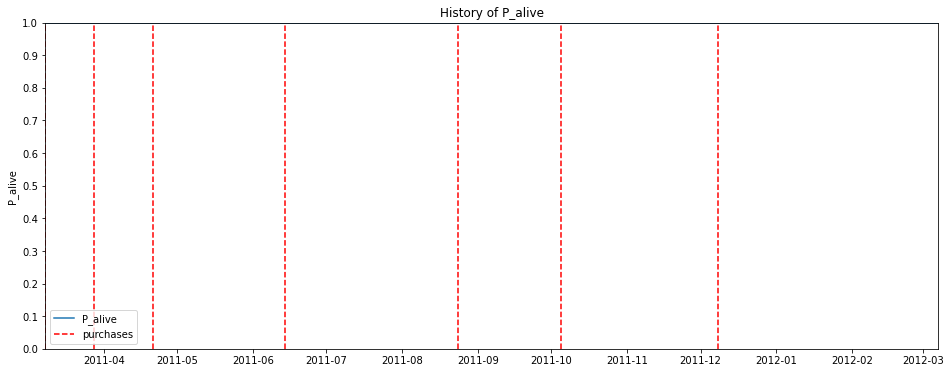

In [45]:
fig = plt.figure(figsize=(16,6))
sp_trans = df.loc[df['CustomerID'] == 14730]
plot_history_alive(betageofit, 365, sp_trans, 'InvoiceDate')

### Let's see the summary of customers

In [46]:
summ = data[data['frequency']>0]

In [48]:
print(summ.head())
print(len(summ))

            frequency  recency      T  monetary_value  Purchases_Predicted
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015656
12348.0           3.0    283.0  358.0      301.480000             0.008956
12352.0           6.0    260.0  296.0      368.256667             0.018697
12356.0           2.0    303.0  325.0      269.905000             0.007172
12358.0           1.0    149.0  150.0      683.200000             0.008340
2790


### Let's see the correlation between monetary value and frequency

In [49]:
summ[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


### Now let's use GammaGammaFitter

In [52]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(summ['frequency'],
        summ['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [53]:
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


### Now let's see the expected average profit for some customers

In [54]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(15))

CustomerID
12346.0     416.917667
12347.0     569.988807
12348.0     333.762672
12349.0     416.917667
12350.0     416.917667
12352.0     376.166864
12353.0     416.917667
12354.0     416.917667
12355.0     416.917667
12356.0     324.008941
12357.0     416.917667
12358.0     539.930643
12359.0    1515.282839
12360.0     652.217077
12361.0     416.917667
dtype: float64


In [56]:
betageofit.fit(data['frequency'], data['recency'], data['T'])

print(ggf.customer_lifetime_value(
    betageofit, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

CustomerID
12346.0     295.248495
12347.0    3010.933997
12348.0    1008.692677
12349.0    1337.106427
12350.0     306.932977
12352.0    2372.739690
12353.0     426.098903
12354.0     386.464312
12355.0     411.043379
12356.0     784.161526
Name: clv, dtype: float64


In [58]:
pip install create-license

Note: you may need to restart the kernel to use updated packages.
